In [34]:
import pandas as pd
import matplotlib.pyplot as plt

In [35]:
# Load the data$
root_dir = '../'
linear_torque_cmd_file = root_dir + 'data/sys_id/linear_torque_cmd.csv'
step_torque_cmd_file = root_dir + 'data/sys_id/step_torque_cmd.csv'
linear_torque_cmd = pd.read_csv(linear_torque_cmd_file, index_col=0)
step_torque_cmd = pd.read_csv(step_torque_cmd_file, index_col=0)

# First look at the data
linear_torque_cmd.head()

,VSI_Motor_Speed_RR,VSI_Motor_Speed_RL,VSI_Motor_Speed_FR,VSI_Motor_Speed_FL,VSI_TrqFeedback_RR,VSI_TrqFeedback_RL,VSI_TrqFeedback_FR,VSI_TrqFeedback_FL
0.00,0.0,0.0,0.0,0.0,0.00000,-0.12936,0.0,0.00000
0.01,0.0,0.0,0.0,0.0,0.00000,-0.12936,0.0,0.00000
0.02,0.0,0.0,0.0,0.0,-0.12936,0.00000,0.0,-0.12936
0.03,0.0,0.0,0.0,0.0,0.00000,-0.12936,0.0,-0.12936
0.04,0.0,0.0,0.0,0.0,-0.25872,0.00000,0.0,-0.12936


In [36]:
wheel_names = ['FL', 'FR', 'RL', 'RR']
speed_names = [f'VSI_Motor_Speed_{wheel}' for wheel in wheel_names]
torque_names = [f'VSI_TrqFeedback_{wheel}' for wheel in wheel_names]

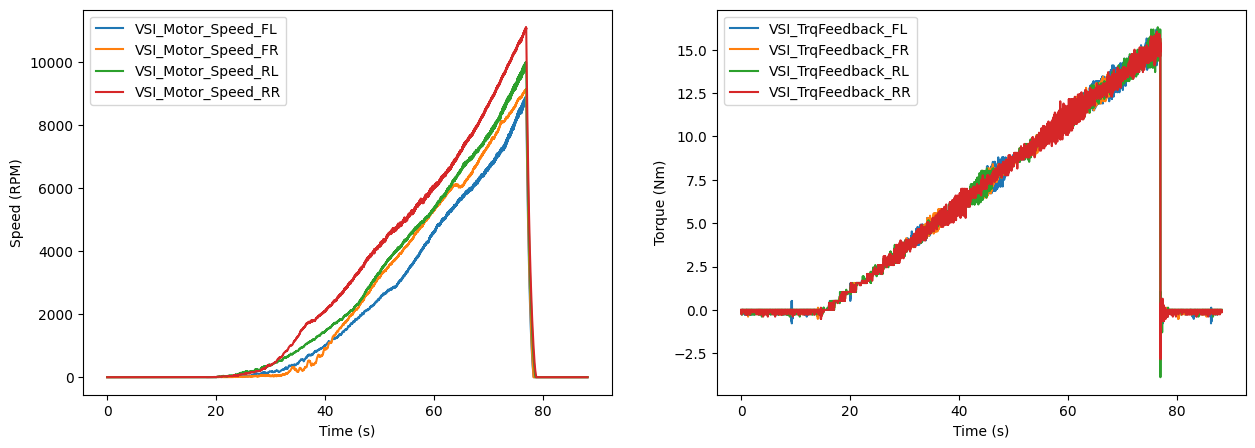

In [37]:
# Plot the linear torque command data
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
linear_torque_cmd[speed_names].plot(ax=ax[0], xlabel='Time (s)', ylabel='Speed (RPM)')
linear_torque_cmd[torque_names].plot(ax=ax[1], xlabel='Time (s)', ylabel='Torque (Nm)')
plt.show()

In [38]:
# Create Torque-Speed pandas series
linear_torque_cmd[[torque_names[0], speed_names[0]]].set_index(torque_names[0])

,VSI_Motor_Speed_FL
VSI_TrqFeedback_FL,
0.00000,0.0
0.00000,0.0
-0.12936,0.0
-0.12936,0.0
-0.12936,0.0
...,...
0.00000,0.0
0.00000,0.0
0.00000,0.0


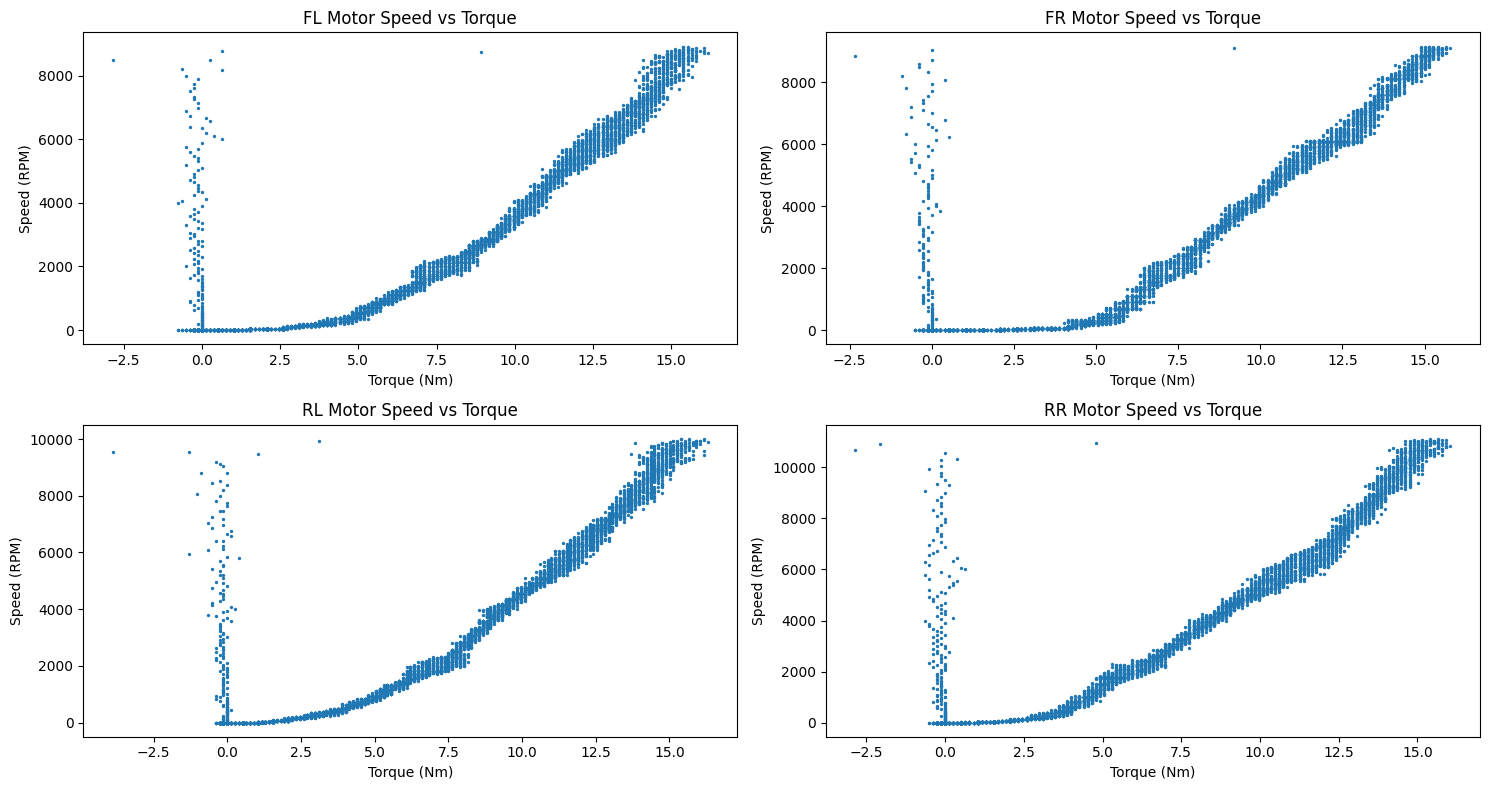

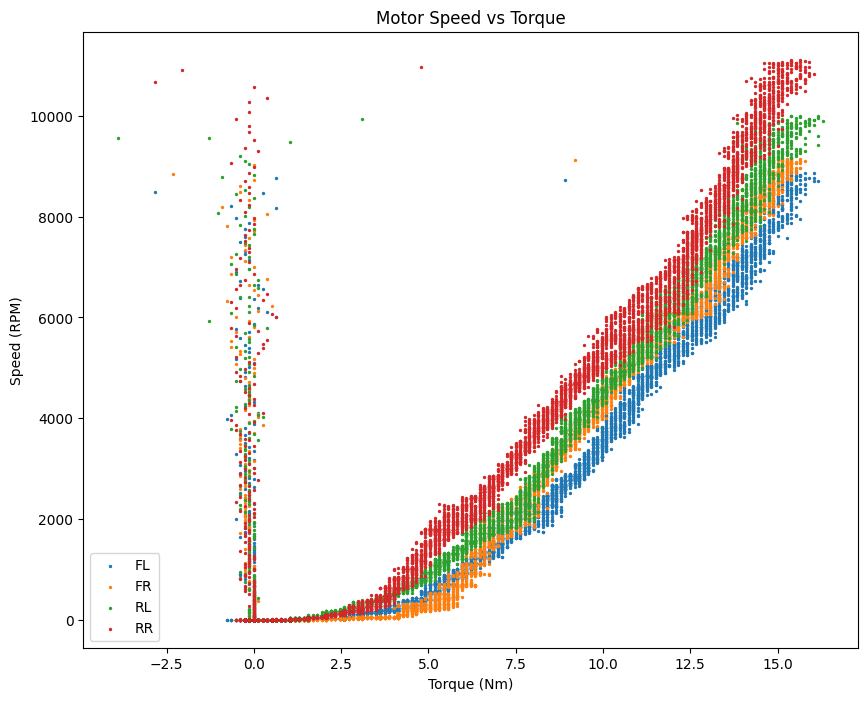

In [39]:
# For each wheel, plot the motor speed vs torque
fig, ax = plt.subplots(2, 2, figsize=(15, 8))
for i, wheel in enumerate(wheel_names):
    ax[i//2, i%2].scatter(linear_torque_cmd[torque_names[i]], linear_torque_cmd[speed_names[i]], s=2)
    ax[i//2, i%2].set_xlabel('Torque (Nm)')
    ax[i//2, i%2].set_ylabel('Speed (RPM)')
    ax[i//2, i%2].set_title(f'{wheel} Motor Speed vs Torque')
plt.tight_layout()

# PLot on a single graph
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
for i, wheel in enumerate(wheel_names):
    ax.scatter(linear_torque_cmd[torque_names[i]], linear_torque_cmd[speed_names[i]], s=2, label=wheel)
ax.set_xlabel('Torque (Nm)')
ax.set_ylabel('Speed (RPM)')
ax.set_title('Motor Speed vs Torque')
ax.legend()
plt.show()

In [40]:
# Fit a linear model to the data
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

# Fit a linear model to the data
def fit_linear_model(data, x_col, y_col):
    X = data[x_col].values.reshape(-1, 1)
    y = data[y_col].values
    model = LinearRegression().fit(X, y)
    y_pred = model.predict(X)
    mse = mean_squared_error(y, y_pred)
    return model, mse

# Fit a linear model to the data
def fit_linear_models(data, x_cols, y_cols):
    models = {}
    mses = {}
    for x_col, y_col in zip(x_cols, y_cols):
        model, mse = fit_linear_model(data, x_col, y_col)
        models[(x_col, y_col)] = model
        mses[(x_col, y_col)] = mse
    return models, mses

# Fit the linear models
linear_models, linear_mses = fit_linear_models(linear_torque_cmd, torque_names, speed_names)
linear_mses

{('VSI_TrqFeedback_FL', 'VSI_Motor_Speed_FL'): 1020349.3964356044,
 ('VSI_TrqFeedback_FR', 'VSI_Motor_Speed_FR'): 1186308.6352304136,
 ('VSI_TrqFeedback_RL', 'VSI_Motor_Speed_RL'): 1150228.7531030348,
 ('VSI_TrqFeedback_RR', 'VSI_Motor_Speed_RR'): 1214377.210375969}

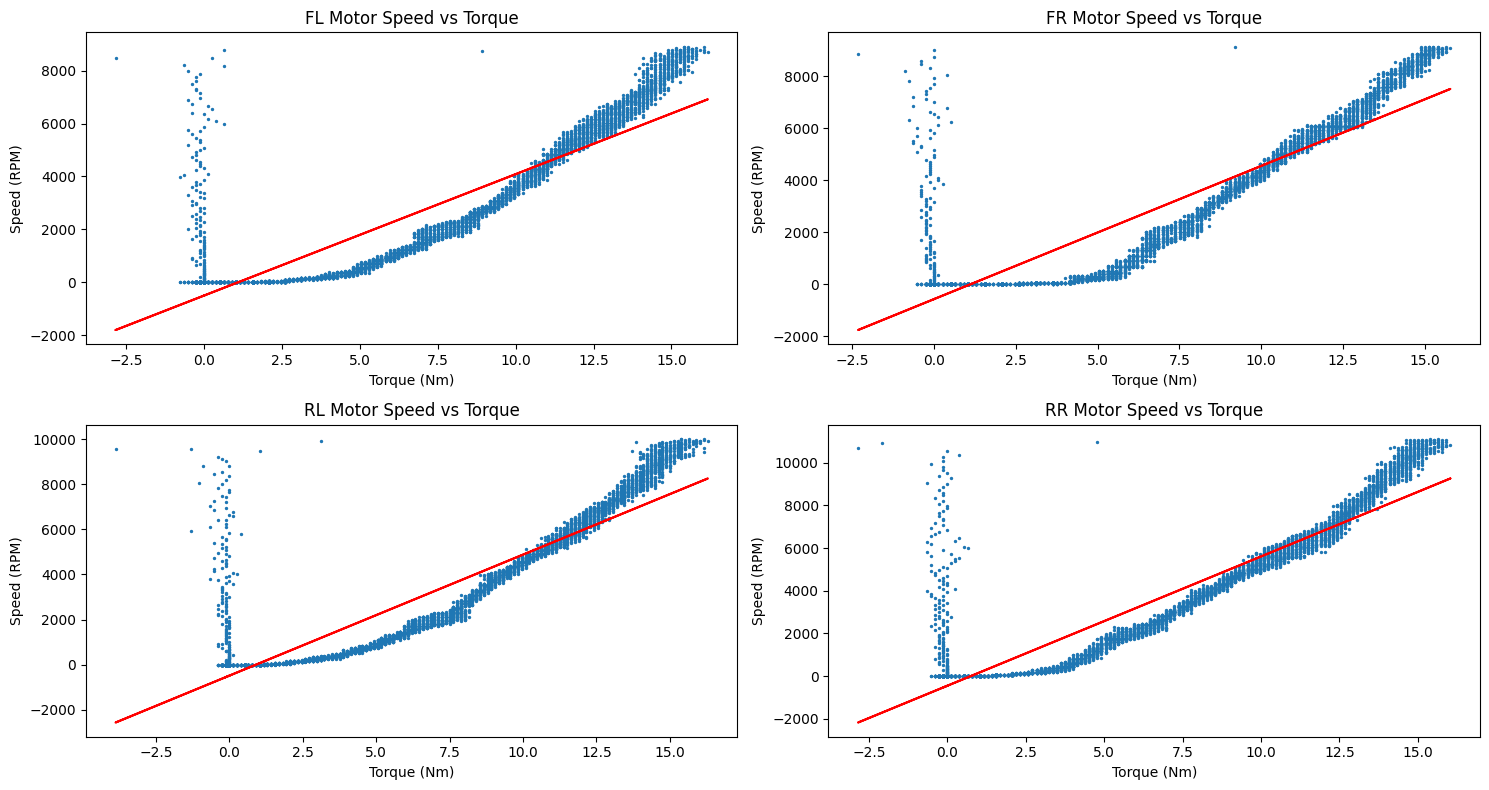

In [41]:
# Plot the linear model fits
fig, ax = plt.subplots(2, 2, figsize=(15, 8))
for i, wheel in enumerate(wheel_names):
    x_col = torque_names[i]
    y_col = speed_names[i]
    model = linear_models[(x_col, y_col)]
    x = linear_torque_cmd[x_col].values
    y = linear_torque_cmd[y_col].values
    y_pred = model.predict(x.reshape(-1, 1))
    ax[i//2, i%2].scatter(x, y, s=2)
    ax[i//2, i%2].plot(x, y_pred, color='red')
    ax[i//2, i%2].set_xlabel('Torque (Nm)')
    ax[i//2, i%2].set_ylabel('Speed (RPM)')
    ax[i//2, i%2].set_title(f'{wheel} Motor Speed vs Torque')
plt.tight_layout()

In [42]:
# Filter outliers
def filter_outliers(data, x_col, y_col, threshold=0.1):
    model = linear_models[(x_col, y_col)]
    x = data[x_col].values
    y = data[y_col].values
    y_pred = model.predict(x.reshape(-1, 1))
    residuals = np.abs(y - y_pred)
    mask = residuals < threshold
    return data[mask]

# Filter outliers
filtered_data = linear_torque_cmd
for x_col, y_col in zip(torque_names, speed_names):
    filtered_data = filter_outliers(filtered_data, x_col, y_col)
    
# Fit the linear models
filtered_models, filtered_mses = fit_linear_models(filtered_data, torque_names, speed_names)
filtered_mses

ValueError: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required by LinearRegression.

In [ ]:
# Plot the filtered linear model fits
fig, ax = plt.subplots(2, 2, figsize=(15, 8))
for i, wheel in enumerate(wheel_names):
    x_col = torque_names[i]
    y_col = speed_names[i]
    model = filtered_models[(x_col, y_col)]
    x = filtered_data[x_col].values
    y = filtered_data[y_col].values
    y_pred = model.predict(x.reshape(-1, 1))
    ax[i//2, i%2].scatter(x, y, s=2)
    ax[i//2, i%2].plot(x, y_pred, color='red')
    ax[i//2, i%2].set_xlabel('Torque (Nm)')
    ax[i//2, i%2].set_ylabel('Speed (RPM)')
    ax[i//2, i%2].set_title(f'{wheel} Motor Speed vs Torque')
plt.tight_layout()


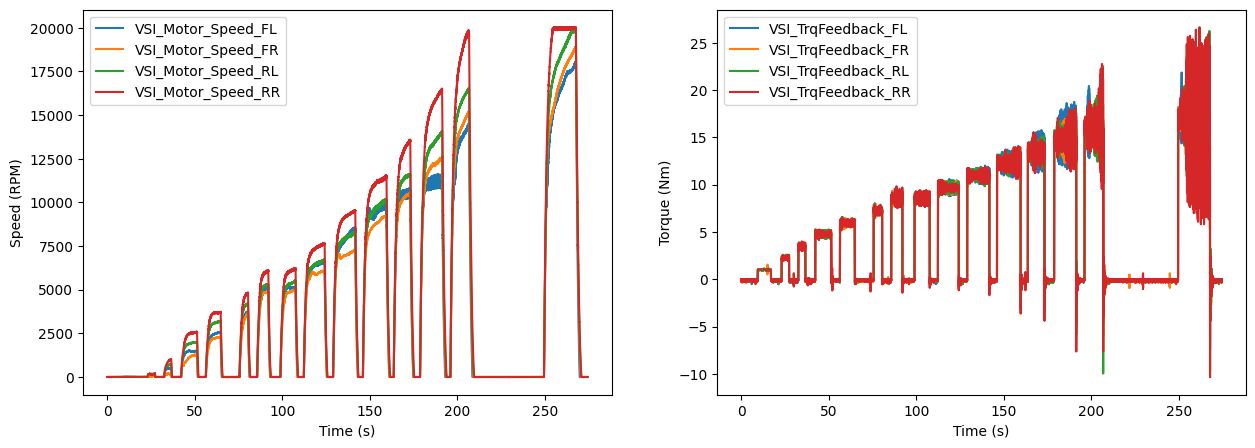

In [44]:
# Plot the step torque command data
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
step_torque_cmd[speed_names].plot(ax=ax[0], xlabel='Time (s)', ylabel='Speed (RPM)')
step_torque_cmd[torque_names].plot(ax=ax[1], xlabel='Time (s)', ylabel='Torque (Nm)')
plt.show()

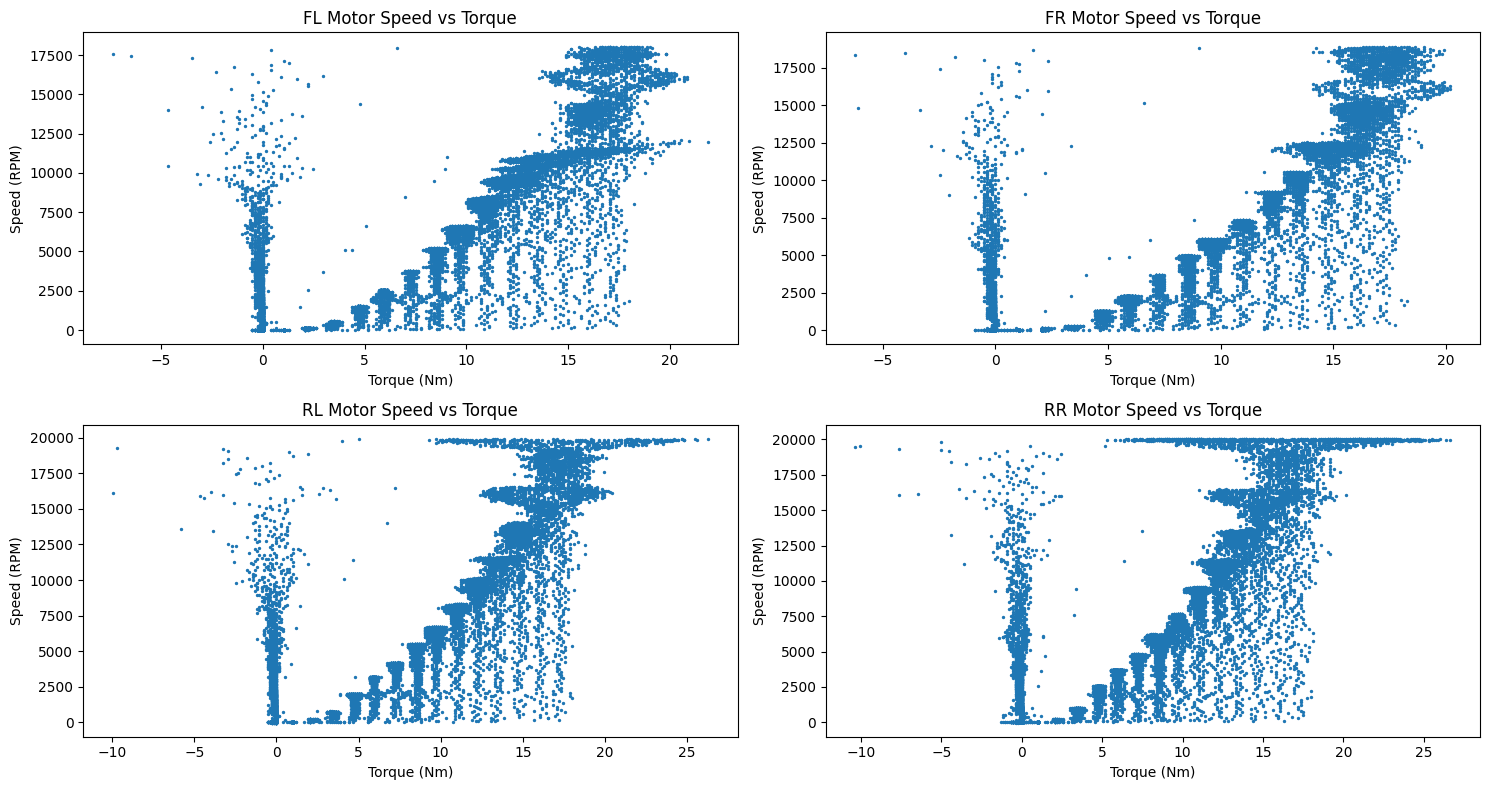

In [43]:
# For each wheel, plot the motor speed vs torque
fig, ax = plt.subplots(2, 2, figsize=(15, 8))
for i, wheel in enumerate(wheel_names):
    ax[i//2, i%2].scatter(step_torque_cmd[torque_names[i]], step_torque_cmd[speed_names[i]], s=2)
    ax[i//2, i%2].set_xlabel('Torque (Nm)')
    ax[i//2, i%2].set_ylabel('Speed (RPM)')
    ax[i//2, i%2].set_title(f'{wheel} Motor Speed vs Torque')
plt.tight_layout()
plt.show()